## 0.3 - Developing a greedy algorithm

This notebook will contain a simple greedy algorithm created used the functions constructed in the notebook 0.2. 

The greedy algorithm starts with a given request (*request 1*). Then:
- assign one request at a time and store its *tf* (instant of time the request leaves the last bath)
- the request which yields the lowest *tf* is assigned
- repeat previous steps until there are no requests to be assigned

After this first algorithm, greedy algorithms with different indicators will be tested.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from src import ps
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [3]:
ss = ps.Schedule()
ss.load_data('prueba', 8)

In [4]:
# Implementation of the greedy algorithm

first = 0

tb1, ts1, tf1 = ss.first_assignment(first)

_tb = [None for _ in range(ss.N)]
_ts = [None for _ in range(ss.N)]
_tf = [None for _ in range(ss.N)]
tb_aux, ts_aux, tf_aux = [], [], []

_tb[first], _ts[first], _tf[first] = tb1.copy(), ts1.copy(), tf1.copy()

unused_requests = set(range(ss.N)) - {first}

order = [first]

while len(unused_requests) > 0:
    ds = []
    new = True
    ds_opt = 0

    for i in unused_requests:
        tb2, ts2, tf2 = ss.assign_new_request(tb1, ts1, tf1, i)

        ds.append(tf2)

        if ds[-1] < ds_opt or new:
            ds_opt = ds[-1].copy()
            tb_opt, ts_opt, tf_opt = tb2.copy(), ts2.copy(), tf2.copy()
            i_add = i
            new = False

    new = True
    unused_requests -= {i_add}
    order.append(i_add)

    _tb[i_add] = tb_opt.copy()
    _ts[i_add] = ts_opt.copy()
    _tf[i_add] = tf_opt.copy()

    tb1, ts1, tf1 = tb_opt.copy(), ts_opt.copy(), tf_opt.copy()


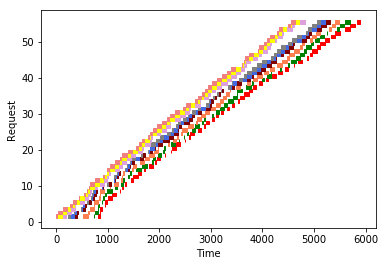

In [5]:
fig, ax = plt.subplots()
co = ['lightcoral', 'yellow', 'plum', 'grey', 'royalblue', 'maroon', 'coral', 'g', 'red', 'sienna']

ax.set_xlabel('Time')
ax.set_ylabel('Request')

pp = 0

for i in order:
    pp += 1
    ax.broken_barh(ss.compute_Vb(_tb[i], _ts[i], _tf[i]), yrange=(pp,1), color=co)

In [6]:
max(_tf)

5898.0

### Testing indicators

In [7]:
def assign_all(first, method):

    tb1, ts1, tf1 = ss.first_assignment(first)

    _tb = [None for _ in range(ss.N)]
    _ts = [None for _ in range(ss.N)]
    _tf = [None for _ in range(ss.N)]
    tb_aux, ts_aux, tf_aux = [], [], []

    _tb[first], _ts[first], _tf[first] = tb1.copy(), ts1.copy(), tf1.copy()

    unused_requests = set(range(ss.N)) - {first}

    order = [first]

    while len(unused_requests) > 0:
        ds = []
        new = True
        ds_opt = 0

        for i in unused_requests:
            tb2, ts2, tf2 = ss.assign_new_request(tb1, ts1, tf1, i)
            
            if method == 'tf':
                ds.append(tf2)
            elif method == 'id':
                ds.append(idle_time(tb1, ts1, tf1, tb2, ts2, tf2))
            elif method == 'itf':
                ds.append(idle_time(tb1, ts1, tf1, tb2, ts2, tf2) * tf2)
            elif method == 'ef':
                ds.append(idle_time(tb1, ts1, tf1, tb2, ts2, tf2) * efficiency(tb2, ts2, tf2, i) * tf2)
            elif method == 'wid':
                ds.append(weighted_idle_time(tb1, ts1, tf1, tb2, ts2, tf2))
            elif method == 'wt':
                ds.append(weighted_idle_time(tb1, ts1, tf1, tb2, ts2, tf2) * tf2)
               

            if ds[-1] < ds_opt or new:
                ds_opt = ds[-1].copy()
                tb_opt, ts_opt, tf_opt = tb2.copy(), ts2.copy(), tf2.copy()
                i_add = i
                new = False

        new = True
        unused_requests -= {i_add}
        order.append(i_add)

        _tb[i_add] = tb_opt.copy()
        _ts[i_add] = ts_opt.copy()
        _tf[i_add] = tf_opt.copy()

        tb1, ts1, tf1 = tb_opt.copy(), ts_opt.copy(), tf_opt.copy()
    
    return _tb, _ts, _tf, order

In [8]:
result = dict()

#### Indicator: *tf*

In [10]:
%%time
result['tf'] = [0 for _ in range(ss.N)]

for i in range(ss.N):
    tb_, ts_, tf_, order_ = assign_all(i, 'tf')
    result['tf'][i] = max(tf_)

Wall time: 6.84 s


#### Indicator: *idle time*

It is based on the idea that idle times should be minimized. It computes the difference between the time a request's bath ends and the time the same bath for the next request starts. Then, it returns the sum of the absolute values. 

In [23]:
def idle_time(tb1, ts1, tf1, tb2, ts2, tf2):
    
    _dis = [abs(tb2[j] - tb1[j + 1]) if j + 1 not in ss.b else abs(tb2[j] - ts1[ss.b.index(j + 1)]) for j in range(ss.M - 1)]
    _dis.append(abs(tf1 - tb2[-1]))

    return sum(_dis)

In [24]:
%%time
result['id'] = [0 for _ in range(ss.N)]

for i in range(ss.N):
    tb_, ts_, tf_, order_ = assign_all(i, 'id')
    result['id'][i] = max(tf_)

Wall time: 8.44 s


#### Indicator: *idle time x tf*

In [20]:
%%time
result['itf'] = [0 for _ in range(ss.N)]

for i in range(ss.N):
    tb_, ts_, tf_, order_ = assign_all(i, 'itf')
    result['itf'][i] = max(tf_)

Wall time: 9.34 s


#### Indicator: *idle time x efficiency*

In [21]:
def efficiency(tb1, ts1, tf1, index):
    _v1 = ss.compute_Vb(tb1, ts1, tf1)
    used_time = sum([v[1] for v in _v1])
    min_time = sum(ss.tin[index])
    max_time = sum(ss.tax[index])
    
    return (used_time - min_time) / (max_time + 1 - used_time)

In [22]:
%%time
result['ef'] = [0 for _ in range(ss.N)]

for i in range(ss.N):
    tb_, ts_, tf_, order_ = assign_all(i, 'ef')
    result['ef'][i] = max(tf_)

Wall time: 13 s


#### Indicator: *weighted idle time*

It is based on the idea that inefficiency (large idle times) tends to get larger for the last baths. Therefore, it should be given priority to requests whose first baths are close together i.e. have small idle times. For later baths, the inefficiency of the previous requests should 'accommodate' the idle times of the next requests.

In [25]:
def weighted_idle_time(tb1, ts1, tf1, tb2, ts2, tf2):
    
    _dis = [abs(tb2[j] - tb1[j + 1]) ** (j + 1) if j + 1 not in ss.b else abs(tb2[j] - ts1[ss.b.index(j + 1)]) ** (j + 1) for j in range(ss.M - 1)]
    _dis.append(abs(tf1 - tb2[-1]) ** (ss.M))

    return sum(_dis)

In [26]:
%%time
result['wid'] = [0 for _ in range(ss.N)]

for i in range(ss.N):
    tb_, ts_, tf_, order_ = assign_all(i, 'wid')
    result['wid'][i] = max(tf_)

Wall time: 9.66 s


#### Indicator: *weighted idle time x tf*

In [27]:
%%time
result['wt'] = [0 for _ in range(ss.N)]

for i in range(ss.N):
    tb_, ts_, tf_, order_ = assign_all(i, 'wt')
    result['wt'][i] = max(tf_)

Wall time: 9.37 s


### Comparing the results

In [28]:
results_df = pd.DataFrame(result)

In [29]:
results_df['best'] = results_df.idxmin(1)

In [30]:
results_df

,tf,id,itf,ef,wid,wt,best
0,5898.0,5128.0,5564.0,5950.0,5566.0,5564.0,id
1,5746.0,5110.0,5479.0,5967.0,5481.0,5479.0,id
2,5771.0,5130.0,5700.0,5935.0,5702.0,5700.0,id
3,5756.0,5113.0,5487.0,5898.0,5489.0,5487.0,id
4,5841.0,5199.0,5595.0,5948.0,5597.0,5595.0,id
5,5859.0,5125.0,5494.0,5669.0,5494.0,5494.0,id
6,5758.0,5245.0,5564.0,5734.0,5566.0,5564.0,id
7,5759.0,5070.0,5506.0,5910.0,5508.0,5506.0,id
8,5821.0,5320.0,5692.0,5727.0,5694.0,5692.0,id
9,5693.0,5239.0,5576.0,5923.0,5536.0,5576.0,id


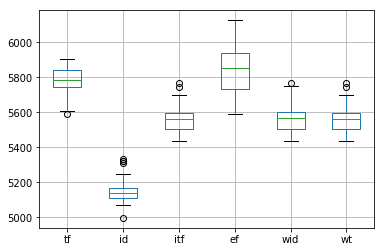

In [31]:
results_df.boxplot(column=['tf', 'id', 'itf', 'ef', 'wid', 'wt']);

In [32]:
results_df.min()

tf      5591
id      4997
itf     5437
ef      5591
wid     5437
wt      5437
best      id
dtype: object

### Testing on a different dataset

In [41]:
ss.load_data('prueba', 1)

In [42]:
def test_indicators(ss, indicators):
    _result = dict()
    
    for ind in indicators:
        _result[ind] = [0 for _ in range(ss.N)]

        for i in range(ss.N):
            tb_, ts_, tf_, order_ = assign_all(i, ind)
            _result[ind][i] = max(tf_)
            
    return _result

In [43]:
result2 = test_indicators(ss, ['id', 'itf', 'wid', 'wt'])

In [44]:
results2_df = pd.DataFrame(result2)
results2_df['best'] = results2_df.idxmin(1)

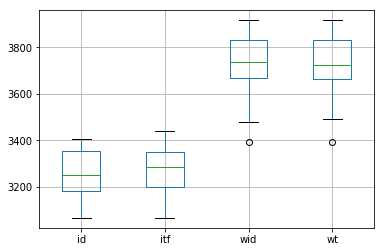

In [45]:
results2_df.boxplot(column=['id', 'itf', 'wid', 'wt']);

In [46]:
results2_df.min()

id      3067
itf     3067
wid     3395
wt      3395
best      id
dtype: object

In [47]:
ps.get_solution_value('prueba', 11)

3266

**Conclusion:** a single indicator can't be used for all datasets.

Options:
* Try to find different indicators
* Try to find a different weighting rule
* Analyse datasets' characteristics that lead to different best-performing indicators and choose rule to define which one to apply
* Train the algorithm and find a linear combination of the indicators that fits well on the majority
* Apply multiple greedy algorithms each one with a different indicator